# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [ ]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-06 20:58:08--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2023-12-06 20:58:09--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.1s    

2023-12-06 20:58:09 (152 MB/s) - ‘data.zip’ saved [17592727/17592727]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
from torchvision import transforms
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        class_name = member.find("name").text
        class_label = class_dict.get(class_name)
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)

        res = (xmin, ymin, xmax, ymax, class_label)

        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

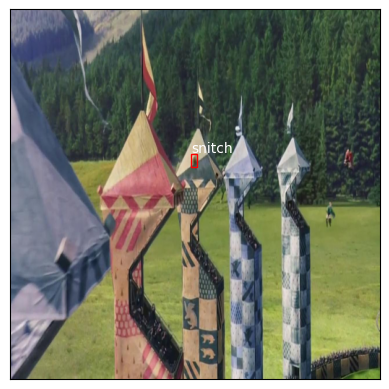

In [ ]:
for batch in train_ds:
    break

unnormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
t = unnormalize(batch['image'])

fig, ax = plt.subplots(1)
ax.imshow(t.cpu().numpy().transpose(1, 2, 0))
bboxes = batch['bboxes']
for bbox in bboxes:
    xmin, ymin, xmax, ymax, classlabel = bbox
    rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    classname = train_ds.class_dict_inv.get(classlabel)
    ax.text(xmin, ymin - 2, classname, color='white', fontsize=10)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [ ]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        unnormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
        t = unnormalize(images[i])

        ax.imshow(t.cpu().numpy().transpose(1, 2, 0))
        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, classlabel = bbox
            rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            classname = train_ds.class_dict_inv.get(int(classlabel))
            ax.text(xmin, ymin - 2, classname, color='white', fontsize=10)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

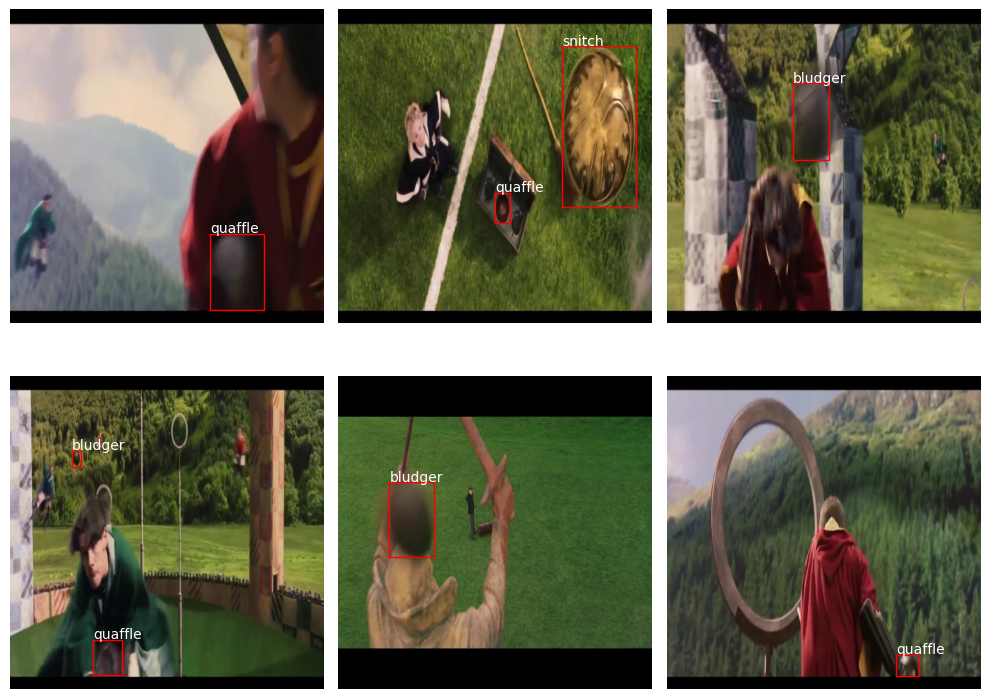

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))
    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape
    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )
        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        w_box = (xmax - xmin) / (downsample * 16) # TODO ширина бокса отнормированная
        h_box = (ymax - ymin) / (downsample * 16) # TODO высота бокса отнормированная

        # Посчитайте координаты центра и сдвиги
        cx = (xmax + xmin) // 2 # TODO (координаты центра в исходных координатах)
        cy = (ymax + ymin) // 2 # TODO
        cx_idx = cx // downsample # TODO (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx = cy // downsample # TODO

        cx_box = (cx - cx_idx * downsample) / downsample # TODO (посчитайте сдивиги относительно cx_idx)
        cy_box = (cy - cy_idx * downsample) / downsample

        target[i, :, cy_idx.to(torch.long), cx_idx.to(torch.long)] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

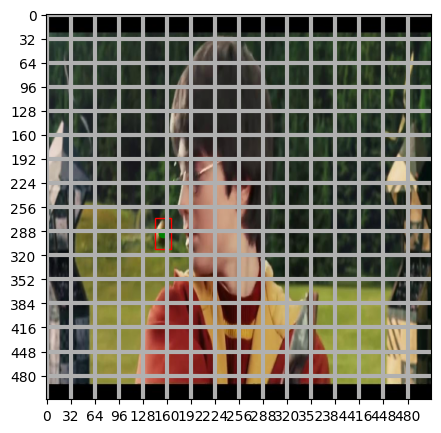

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    batches_num, _, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    ### YOUR CODE HERE ###
    batches_decoded = []
    for i in range(batches_num):
        result = decode_batch(pred[i, :, :, :], img_w, img_h, upsample, threshold)
        batches_decoded.append(result)
    return batches_decoded


def decode_batch(prediction, img_w, img_h, upsample, threshold):
    channels_num, h, w = prediction.shape
    decoded_bboxes = []
    for i in range(h):
        for j in range(w):
            vec = prediction[:, i, j]
            if (vec[4] < threshold):
                continue
            cx_box, cy_box, w_box, h_box = vec[0], vec[1], vec[2], vec[3]

            cx = cx_box * upsample + j * upsample
            cy = cy_box * upsample + i * upsample
            w_real = w_box * img_w
            h_real = h_box * img_h

            xmin, ymin, xmax, ymax = find_coords(cx, cy, w_real, h_real)
            clazz = find_class(vec[5:])

            decoded_bboxes.append((xmin, ymin, xmax, ymax, clazz))
    return decoded_bboxes


def find_coords(cx, cy, w, h):
    ymin = cy - h // 2
    xmin = cx - w // 2
    ymax = cy + h // 2
    xmax = cx + h // 2
    return xmin, ymin, xmax, ymax


def find_class(v):
    if len(v) == 1:
        return v[0]
    return np.argmax(v)

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [ ]:
C =  len(train_ds.class_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
        self.channel_reducer = nn.Sequential(
            nn.Conv2d(2048, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 5 + C, 3, padding=1),
            nn.BatchNorm2d(5 + C), # с ним лучше результаты
            # Мотивация: нормализованные данные на входе позволяют сигмоиде быть более "разношерстной"
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.to(device)
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.channel_reducer(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
detector = Detector().to(device)
input_image = torch.randn(16, 3, 512, 512)
output_features = detector(input_image)
print(output_features.shape)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 32.9MB/s]


torch.Size([16, 8, 16, 16])


## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [ ]:
import torch.nn.functional as F

def special_loss(pred, target, check=False, C=C):
    b, c, h, w = pred.shape
    masks = (target[:, 4, :, :] == 1) # маска формы b h w

    selected_pred = None
    selected_target = None

    for chan in range(c):
        sel_pred = torch.masked_select(pred[:, chan, :, :], masks)
        if (selected_pred == None):
            selected_pred = sel_pred
        else:
            selected_pred = torch.vstack((selected_pred, sel_pred))
    selected_pred = selected_pred.transpose(1, 0)
    # по идее получили набор каналов bbox (cx_box, cy_box, w_box, h_box, confidence, prob0, prob1, prob2)

    for chan in range(6):
        sel_target = torch.masked_select(target[:, chan, :, :], masks)
        if (selected_target == None):
            selected_target = sel_target
        else:
            selected_target = torch.vstack((selected_target, sel_target))
    selected_target = selected_target.transpose(1, 0)

    # MSE по координатам бокса - индексы 0 и 1
    localization_loss = F.mse_loss(selected_pred[:, 0], selected_target[:, 0], reduction='sum') +\
                        F.mse_loss(selected_pred[:, 1], selected_target[:, 1], reduction='sum')

    # MSE от корней ширины и высоты bbox (cx_box, cy_box, w_box, h_box - индексы 2 и 3)
    box_loss = F.mse_loss(torch.sqrt(selected_pred[:, 2]), torch.sqrt(selected_target[:, 2]), reduction='sum') +\
               F.mse_loss(torch.sqrt(selected_pred[:, 3]), torch.sqrt(selected_target[:, 3]), reduction='sum')

    # Кросс-энтропия по вероятностям классов и классу из таргета - индексы 5 6 7 (или просто 5 для таргета)
    classification_loss = F.cross_entropy(selected_pred[:, 5:], selected_target[:, 5].long(), reduction='sum')

    # Бинарная кросс-энтропия факта наличия объекта
    weights = selected_target[:, 4] + (1 - selected_target[:, 4]) * 0.1
    confidence_loss = F.binary_cross_entropy(selected_pred[:, 4], selected_target[:, 4], weight=weights, reduction='sum')

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 6, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  20
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=1e-5)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        inputs, targets = batch['image'], batch['target']
        inputs, targets = inputs.to(device), targets.to(device)

        opt.zero_grad()
        outputs = model(inputs)
        loss = special_loss(outputs, targets)

        loss.backward()
        opt.step()

        pbar.set_postfix({"Loss": loss.item()})
        epoch_losses.append(loss.item())

    scheduler.step()

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 done; Train loss 15.638;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 9.717;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 7.662;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 6.918;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 6.668;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 6.404;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 6.254;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 6.148;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 6.150;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 6.244;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 6.201;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 6.077;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 5.992;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 5.961;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 5.944;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 5.938;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 5.936;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 5.935;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 5.934;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 5.934;


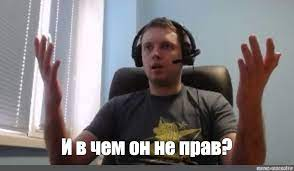

Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu
inputs, targets = batch['image'], batch['target']
inputs, targets = inputs.to(device), targets.to(device)

outputs = model(inputs)

In [ ]:
res = outputs.cpu().detach().numpy()

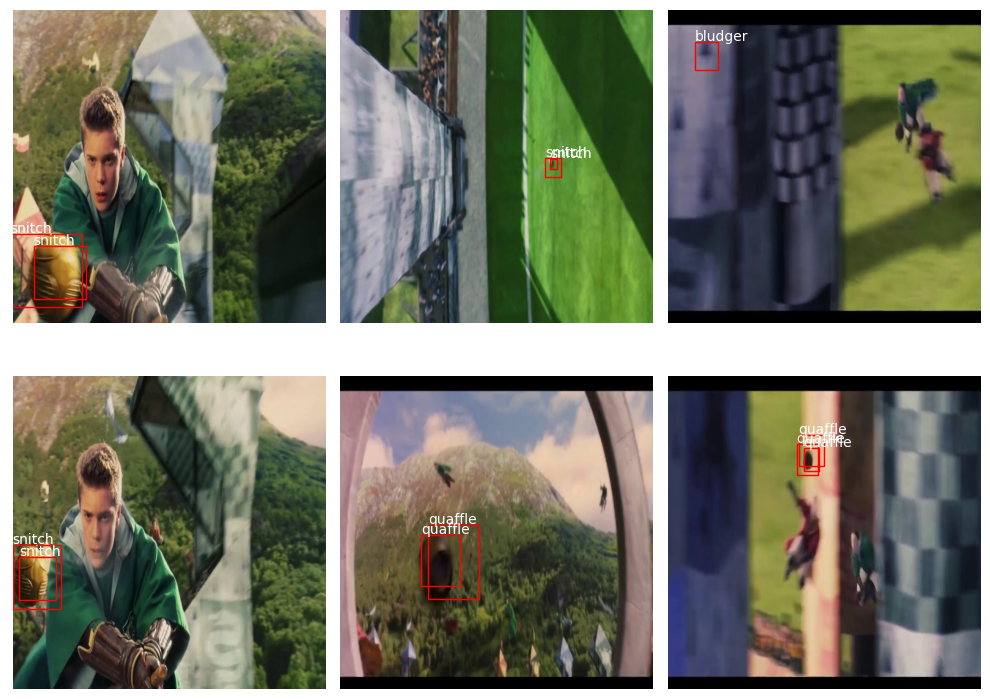

In [ ]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1
pred = decode_prediction(res, threshold=0.995) # или повысить до 0.9999999999999
visualize(inputs, pred)

## Без батчнорма

In [ ]:
C =  len(train_ds.class_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DetectorNoBatchnorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
        self.channel_reducer = nn.Sequential(
            nn.Conv2d(2048, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 5 + C, 3, padding=1),
            #nn.BatchNorm2d(5 + C), # с ним лучше результаты
            # Мотивация: нормализованные данные на входе позволяют сигмоиде быть более "разношерстной"
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.to(device)
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.channel_reducer(x)
        return x

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  20
model = DetectorNoBatchnorm().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=1e-5)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        inputs, targets = batch['image'], batch['target']
        inputs, targets = inputs.to(device), targets.to(device)

        opt.zero_grad()
        outputs = model(inputs)
        loss = special_loss(outputs, targets)

        loss.backward()
        opt.step()

        pbar.set_postfix({"Loss": loss.item()})
        epoch_losses.append(loss.item())

    scheduler.step()

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 done; Train loss 13.787;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 9.524;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 7.490;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 7.023;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 6.860;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 6.668;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 6.789;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 6.394;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 6.257;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 6.224;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 6.220;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 6.145;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 6.051;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 5.999;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 5.964;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 5.944;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 5.939;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 5.937;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 5.936;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 5.936;


In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

# Нужно сделать предсказание и переложить результат на cpu
inputs, targets = batch['image'], batch['target']
inputs, targets = inputs.to(device), targets.to(device)

outputs = model(inputs)

res = outputs.cpu().detach().numpy()

# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

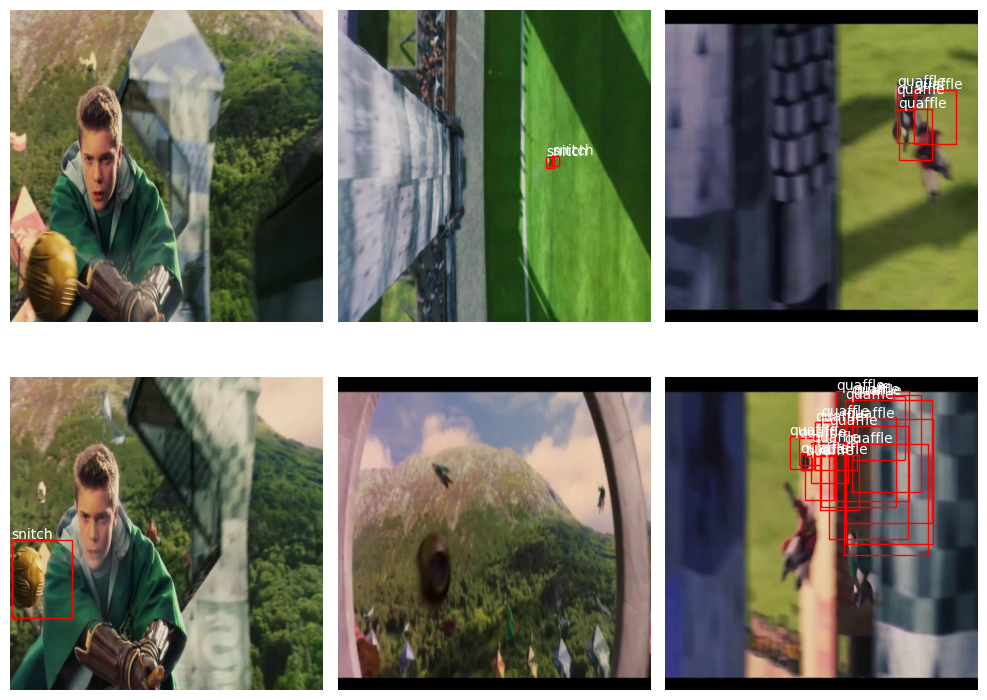

In [ ]:
pred = decode_prediction(res, threshold=0.9999)
visualize(inputs, pred)

Думаю, я оправдал юзание батчнорма вопреки условиям (а может я неправильно понял условие, бывает). Но может это заплатка какой-то более серьезной проблемы, буду благодарен если по возможности укажут это в фидбеке

👍 (🤥)

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 10.5 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    res = []
    for b in bboxes:
        xmin, ymin, xmax, ymax, classlabel = b
        cx = (xmin + xmax) / (2 * w_im)
        cy = (ymin + ymax) / (2 * h_im)

        bw = (xmax - xmin) / w_im
        bh = (ymax - ymin) / h_im

        res.append(str(classlabel) + " " + str(cx) + " " + str(cy) + " " + str(bw) + " " + str(bh))
    return res

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
train_ds.class_dict

{'snitch': 0, 'quaffle': 1, 'bludger': 2}

In [ ]:
# Собираем YAML

nc =  3
names =  ['snitch', 'quaffle', 'bludger']

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
import ultralytics

model = ultralytics.YOLO(model='yolov8n.yaml')  # build a new model from YAML

results = model.train(data = '/content/data.yaml', epochs=100)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /content/train/labels.cache... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.73G      4.716      9.309      4.244         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

                   all         29         34          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.75G      4.389      7.727      4.149         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         29         34          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.73G      3.944      7.518      3.867         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         29         34          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.73G      3.501      6.922      3.503         33        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         29         34          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.73G      3.193      6.188      3.264         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         29         34          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.75G      3.034      5.788      3.024         31        640: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         29         34          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.75G      2.875      5.453      2.699         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         29         34          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.75G      2.811       4.76      2.662         36        640: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         29         34          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.75G      2.755      4.592      2.525         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         29         34    0.00036     0.0939   0.000246   9.04e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.75G      2.734       4.28      2.486         29        640: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         29         34   0.000934      0.164      0.039       0.02



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.75G      2.602      3.936      2.327         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         34      0.249     0.0333     0.0381     0.0183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.75G      2.535      3.883      2.351         31        640: 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         29         34      0.284     0.0636     0.0442     0.0169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.75G      2.562      3.845      2.165         31        640: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         29         34       0.46     0.0949     0.0771     0.0406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.75G       2.43      3.541      2.208         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         29         34      0.518        0.1      0.101     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.75G      2.391      3.384      2.069         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         29         34       0.14      0.129      0.072     0.0427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.75G      2.293      3.175      2.092         36        640: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         29         34      0.202      0.164      0.135     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.75G      2.301      3.071      2.101         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         29         34      0.329      0.154      0.167     0.0843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.75G      2.271      3.071      2.036         31        640: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         29         34      0.544      0.133      0.135      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.75G      2.291      3.018      1.948         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         29         34      0.566      0.133      0.144     0.0778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.75G      2.259      2.872      1.996         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         29         34      0.919      0.133      0.163     0.0691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.75G      2.195      2.856      1.966         19        640: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         29         34      0.567      0.164      0.148     0.0919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.75G      2.093      2.652      1.839         35        640: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         29         34      0.199      0.163      0.131     0.0878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.75G      2.063      2.487       1.77         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         29         34      0.247      0.197      0.141     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.75G      2.129      2.595       1.85         20        640: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         29         34      0.319      0.133      0.161      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.75G      1.983      2.328      1.732         36        640: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         29         34      0.658      0.133      0.161      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.75G       1.96      2.404        1.7         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         29         34      0.658      0.133      0.184      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.75G      1.962      2.267      1.695         31        640: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         29         34      0.994      0.133      0.174      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.75G      1.996      2.465      1.775         17        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         29         34      0.245        0.2      0.195      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.75G      1.964      2.269      1.749         27        640: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         29         34      0.657      0.167      0.178      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.75G      1.875      2.264      1.652         36        640: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         29         34      0.266      0.197      0.177      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.75G      1.877      2.084      1.612         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         29         34      0.634      0.164      0.159      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.75G      1.859      2.071      1.544         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         29         34      0.218      0.197      0.171      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.75G      1.823      1.971      1.567         32        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         29         34      0.272      0.167      0.184      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.75G      1.811      2.033      1.627         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29         34      0.651      0.167      0.191      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.75G      1.748      1.876      1.575         28        640: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         29         34      0.281        0.2      0.199      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.75G      1.826      1.994      1.646         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         29         34      0.199        0.2       0.19      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.75G      1.781      1.896      1.578         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         29         34      0.215      0.256      0.167      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.75G      1.713       1.84      1.512         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         29         34       0.61      0.167      0.188      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.75G      1.906      2.016      1.641         27        640: 100%|██████████| 16/16 [00:05<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         29         34      0.193        0.2      0.165      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.75G      1.789      1.969        1.6         20        640: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         29         34      0.329      0.167      0.193      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.75G      1.748      1.858      1.558         37        640: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         29         34      0.284      0.194      0.191      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.75G      1.683      1.749      1.531         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         29         34       0.28        0.2      0.182      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.75G       1.67      1.719      1.501         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         29         34      0.257      0.226      0.197      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.75G      1.687       1.63      1.458         36        640: 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         29         34      0.285      0.198      0.189      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.75G      1.671      1.645      1.504         27        640: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         29         34      0.286        0.2      0.185      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.75G      1.695      1.745      1.448         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         29         34      0.246      0.256      0.145     0.0798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.75G        1.7      1.727      1.469         29        640: 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         29         34      0.872      0.167       0.16     0.0981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.75G      1.644      1.649      1.465         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         29         34      0.271      0.167       0.18       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.75G      1.641      1.605       1.42         27        640: 100%|██████████| 16/16 [00:07<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         29         34      0.286      0.218      0.181       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.75G      1.546      1.498      1.424         29        640: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         29         34      0.239      0.239      0.196      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.75G      1.587      1.569      1.405         29        640: 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         29         34       0.31      0.226      0.188      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.75G      1.574      1.561      1.404         36        640: 100%|██████████| 16/16 [00:07<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         29         34      0.314      0.266      0.214      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.75G      1.584       1.51      1.458         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         29         34      0.311      0.226      0.196      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.75G      1.553      1.438      1.338         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         29         34       0.32      0.228      0.193      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.75G      1.561      1.439      1.387         31        640: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         29         34      0.611        0.2      0.189      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.75G       1.53      1.431      1.371         21        640: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         29         34      0.303      0.249      0.218      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.75G      1.557      1.462      1.377         29        640: 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         29         34      0.245        0.2      0.189      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.75G       1.58      1.436      1.385         30        640: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         29         34      0.279      0.256      0.205      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.75G       1.54      1.451      1.379         37        640: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         29         34      0.279        0.2      0.198      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.75G      1.561      1.377      1.426         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         29         34      0.311      0.226      0.216       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.75G      1.453      1.418      1.368         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         29         34      0.281        0.2       0.19      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.75G      1.475      1.415       1.37         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         29         34      0.354      0.226      0.202      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.75G        1.5      1.352      1.346         24        640: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         29         34      0.305      0.226      0.175      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.75G       1.41      1.218      1.299         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         29         34      0.333      0.226      0.193      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.75G      1.458      1.361      1.339         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         29         34      0.282        0.2      0.192      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.75G      1.417      1.251      1.343         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         29         34      0.367      0.256      0.221      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.75G      1.437      1.223      1.305         37        640: 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         29         34      0.328      0.259      0.237      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.75G      1.448      1.259      1.359         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         29         34       0.28        0.2      0.185      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.75G      1.508      1.314      1.412         28        640: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         29         34      0.281        0.2      0.185      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.75G      1.449       1.22      1.299         35        640: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         29         34      0.351      0.258       0.23      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.75G      1.485      1.282      1.359         28        640: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         29         34      0.255      0.233       0.22      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.75G      1.427      1.218      1.332         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         29         34      0.291       0.23      0.233      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.75G      1.418      1.252        1.3         21        640: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         29         34      0.285      0.197        0.2      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.75G      1.361      1.176      1.312         20        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         29         34      0.307      0.225      0.205      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.75G      1.388      1.179      1.294         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         29         34       0.28      0.289      0.212      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.75G      1.392      1.122      1.296         31        640: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         29         34      0.281      0.264      0.207      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.75G      1.377      1.135      1.294         26        640: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         29         34      0.285      0.197      0.195      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.75G       1.36      1.131      1.286         33        640: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         29         34      0.327      0.289      0.227      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.75G      1.383      1.113      1.239         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         29         34      0.253      0.233      0.224      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.75G      1.337       1.08      1.262         24        640: 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29         34      0.258      0.259      0.232      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.75G      1.292      1.085      1.225         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         29         34      0.307      0.267      0.219      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.75G      1.362      1.157      1.316         19        640: 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         29         34      0.278        0.2      0.197      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.75G      1.324      1.086      1.237         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         29         34      0.256      0.289      0.231      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.75G      1.368      1.143       1.31         26        640: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         29         34      0.289      0.233      0.231      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.75G      1.338      1.083      1.236         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         34      0.274        0.2      0.194      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.75G      1.285      1.029      1.246         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         29         34      0.338      0.226      0.213      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.75G      1.308      1.039      1.261         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         29         34      0.294      0.267      0.222      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.75G       1.35      1.061      1.285         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         29         34      0.299      0.256       0.21      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.75G      1.339      1.007      1.226         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         29         34      0.288      0.255      0.203       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.75G      1.234      1.004      1.175         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         29         34      0.346      0.226      0.208      0.137


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.83G      1.365      1.186      1.283         14        640: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         29         34      0.281      0.249      0.207      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.75G      1.284      1.076      1.229         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         29         34      0.266       0.29      0.239      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.75G      1.292       1.11      1.241         13        640: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         29         34      0.312      0.279      0.243      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.75G      1.289       1.06      1.255         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         29         34      0.241       0.23      0.202      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.75G      1.257      1.037      1.247         15        640: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         29         34      0.244       0.23      0.192      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.75G      1.273       1.03      1.236         18        640: 100%|██████████| 16/16 [00:04<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         29         34      0.245       0.23      0.195      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.75G      1.205      1.029      1.192         15        640: 100%|██████████| 16/16 [00:05<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         29         34      0.285        0.2      0.202       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.75G      1.185     0.9882      1.207         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         29         34      0.286        0.2      0.205      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.75G      1.224     0.9991      1.252         16        640: 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         29         34      0.286      0.199      0.207      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.75G       1.26      1.004      1.235         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         29         34      0.285      0.197      0.208      0.132



100 epochs completed in 0.196 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


                   all         29         34      0.312      0.279      0.243      0.148
                snitch         29         10      0.703        0.7      0.663      0.431
               quaffle         29         11     0.0815     0.0909     0.0132    0.00449
               bludger         29         13       0.15     0.0463     0.0526    0.00985
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train2


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
import os

all_files = os.listdir('/content/valid/images/')
selected_files = np.random.choice(all_files, size=6, replace=False)
selected_files = ['/content/valid/images/' + x for x in selected_files]
selected_files

['/content/valid/images/242.jpg',
 '/content/valid/images/83.jpg',
 '/content/valid/images/279.jpg',
 '/content/valid/images/228.jpg',
 '/content/valid/images/224.jpg',
 '/content/valid/images/51.jpg']

In [ ]:
preds = model(selected_files)


0: 640x640 1 snitch, 1: 640x640 1 quaffle, 2: 640x640 1 snitch, 3: 640x640 1 bludger, 4: 640x640 1 snitch, 5: 640x640 1 quaffle, 37.1ms
Speed: 3.8ms preprocess, 6.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
preds[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'snitch', 1: 'quaffle', 2: 'bludger'}
orig_img: array([[[123, 142, 175],
        [124, 143, 176],
        [124, 143, 176],
        ...,
        [179, 205, 229],
        [179, 205, 229],
        [179, 205, 229]],

       [[123, 142, 175],
        [124, 143, 176],
        [124, 143, 176],
        ...,
        [179, 205, 229],
        [179, 205, 229],
        [179, 205, 229]],

       [[123, 142, 175],
        [124, 143, 176],
        [124, 143, 176],
        ...,
        [179, 205, 229],
        [179, 205, 229],
        [179, 205, 229]],

       ...,

       [[ 74,  82,  41],
        [ 71,  79,  38],
        [ 67,  75,  34],
        ...,
        [ 26,  62,  38],
        [ 25,  61,  37],
        [ 24,  60,  36]],

       [[ 73,  81,  40],
        [ 70,  78,  37],
        [ 66,  74,  33],
        ...,
        [ 26,  62,  38],
        [ 25,  61,  

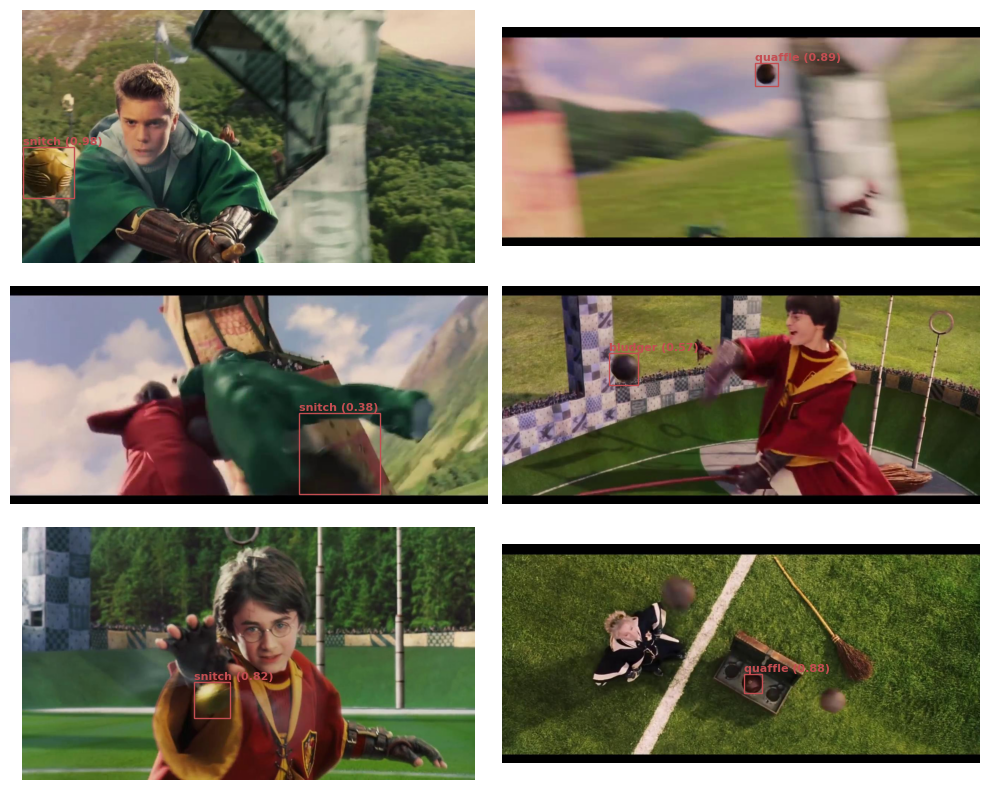

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8), dpi=100)

for i, ax in enumerate(axes.reshape(-1)):

    ax.axis(False)

    if i >= 6:
        break

    img = preds[i].orig_img
    ax.imshow(img[:, :, ::-1])
    bboxes = preds[i].boxes

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox.xyxy.cpu().detach().numpy()[0]
        classlabel = names[int(bbox.cls[0])]
        conf = float(bbox.conf[0])
        rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label_text = f'{classlabel} ({conf:.2f})'
        ax.text(xmin, ymin - 5, label_text, color='r', fontsize=8, weight='bold')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.tight_layout()
plt.show()